# Model Report

In [1]:
import logging
from time import time
from typing import Optional

import arviz as az
import matplotlib.pyplot as plt

from speclet import model_configuration
from speclet.analysis.arviz_analysis import describe_mcmc, summarize_rhat
from speclet.bayesian_models import get_bayesian_model
from speclet.io import project_root
from speclet.loggers import set_console_handler_level
from speclet.managers.cache_manager import (
    get_cached_posterior,
    get_posterior_cache_name,
)
from speclet.project_configuration import get_bayesian_modeling_constants
from speclet.project_enums import ModelFitMethod

/home/jc604/.conda/envs/speclet_smk/bin/../lib/gcc/x86_64-conda-linux-gnu/10.3.0/../../../../x86_64-conda-linux-gnu/bin/ld: /n/app/gcc/6.2.0/lib64/libquadmath.so.0: undefined reference to `memcpy@GLIBC_2.14'
collect2: error: ld returned 1 exit status
/home/jc604/.conda/envs/speclet_smk/bin/../lib/gcc/x86_64-conda-linux-gnu/10.3.0/../../../../x86_64-conda-linux-gnu/bin/ld: /n/app/gcc/6.2.0/lib64/libquadmath.so.0: undefined reference to `memcpy@GLIBC_2.14'
collect2: error: ld returned 1 exit status
/home/jc604/.conda/envs/speclet_smk/bin/../lib/gcc/x86_64-conda-linux-gnu/10.3.0/../../../../x86_64-conda-linux-gnu/bin/ld: /n/app/gcc/6.2.0/lib64/libquadmath.so.0: undefined reference to `memcpy@GLIBC_2.14'
collect2: error: ld returned 1 exit status
/home/jc604/.conda/envs/speclet_smk/bin/../lib/gcc/x86_64-conda-linux-gnu/10.3.0/../../../../x86_64-conda-linux-gnu/bin/ld: /n/app/gcc/6.2.0/lib64/libquadmath.so.0: undefined reference to `memcpy@GLIBC_2.14'
collect2: error: ld returned 1 exit sta

In [2]:
notebook_tic = time()
set_console_handler_level(logging.WARNING)
%config InlineBackend.figure_format = "retina"
HDI_PROB = get_bayesian_modeling_constants().hdi_prob

Parameters for papermill:

- `MODEL_NAME`: name of the model
- `FIT_METHOD`: method used to fit the model; either "ADVI" or "MCMC"
- `CONFIG_PATH`: path to configuration file
- `ROOT_CACHE_DIR`: path to the root caching directory

## Setup

### Papermill parameters

In [3]:
CONFIG_PATH = ""
MODEL_NAME = ""
FIT_METHOD_STR = ""
ROOT_CACHE_DIR = ""

In [4]:
# Parameters
MODEL_NAME = "hnb-single-lineage-prostate"
FIT_METHOD_STR = "PYMC_NUMPYRO"
CONFIG_PATH = "models/model-configs.yaml"
ROOT_CACHE_DIR = "models"

In [5]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)
model_config = model_configuration.get_configuration_for_model(
    config_path=project_root() / CONFIG_PATH, name=MODEL_NAME
)
model = get_bayesian_model(model_config.model)(**model_config.model_kwargs)
trace = get_cached_posterior(
    get_posterior_cache_name(MODEL_NAME, FIT_METHOD),
    cache_dir=project_root() / ROOT_CACHE_DIR,
)

## Fit diagnostics

R-HAT


/home/jc604/.conda/envs/speclet_smk/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


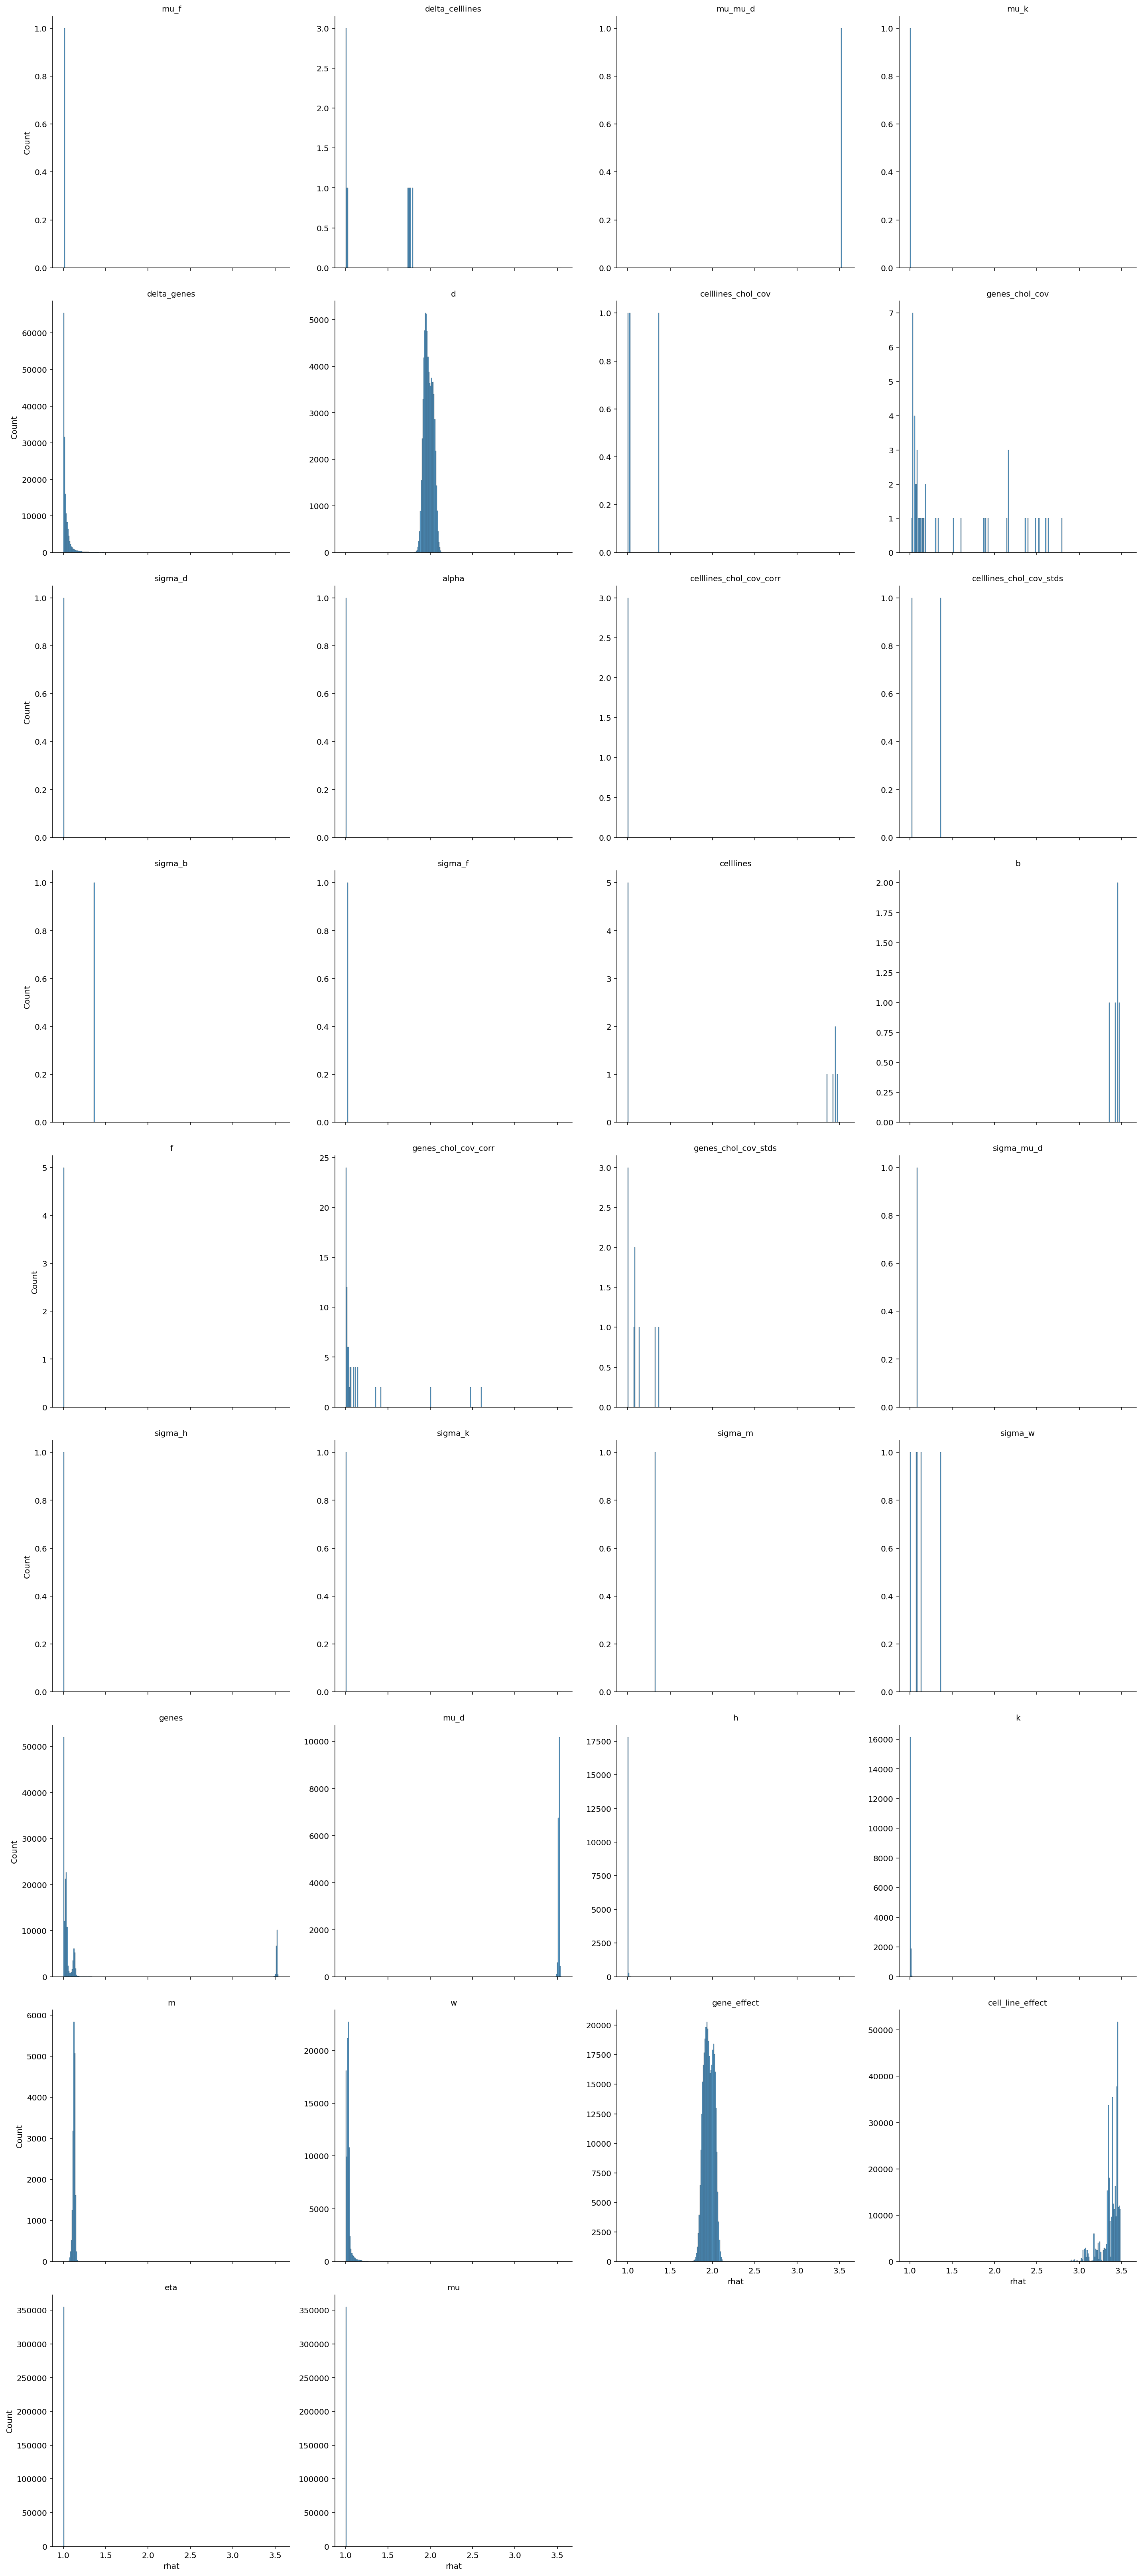

                            count      mean       std       min       25%  \
var_name                                                                    
alpha                         1.0  1.000852       NaN  1.000852  1.000852   
b                             5.0  3.431088  0.049707  3.350463  3.419943   
cell_line_effect         355310.0  3.374873  0.100861  2.895350  3.346091   
celllines                    10.0  2.216615  1.280596  1.001078  1.001334   
celllines_chol_cov            3.0  1.131455  0.204673  1.007043  1.013343   
celllines_chol_cov_corr       3.0  1.002767  0.001893  1.000582  1.002221   
celllines_chol_cov_stds       2.0  1.193533  0.246280  1.019387  1.106460   
d                         71062.0  1.979854  0.053026  1.760815  1.938581   
delta_celllines              10.0  1.384552  0.394458  1.003063  1.009359   
delta_genes              163071.0  1.037247  0.075813  0.999477  1.005219   
eta                      355310.0  1.001412  0.001243  0.999132  1.000567   

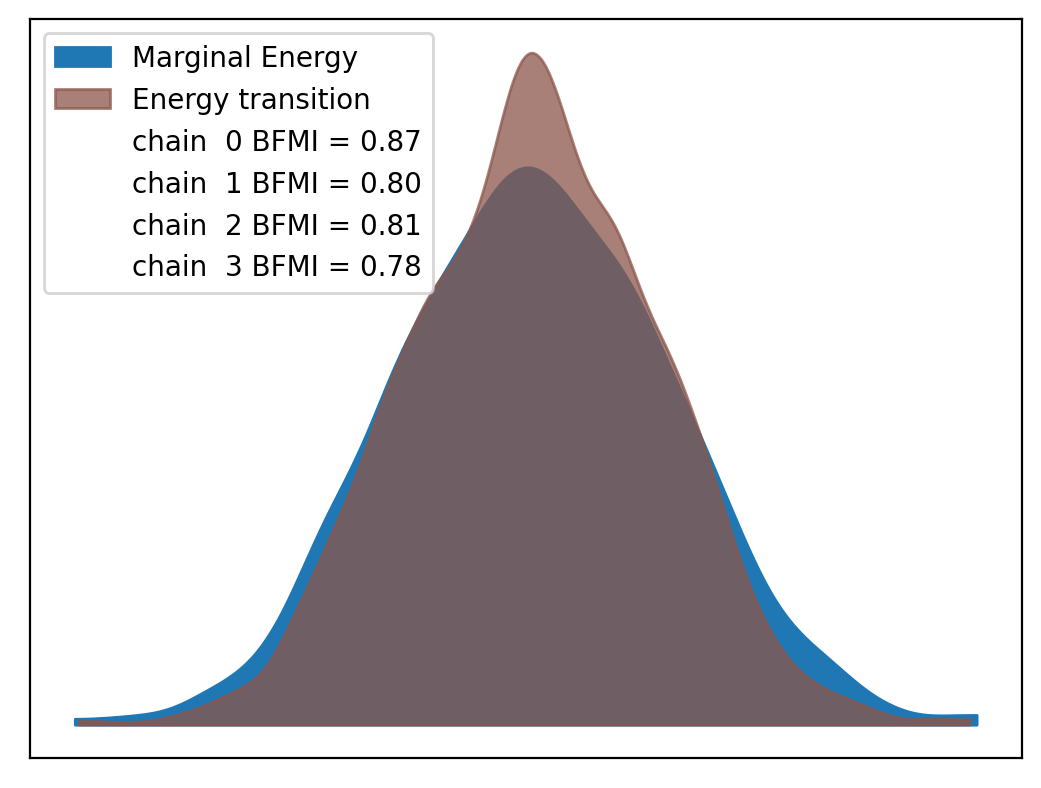

In [6]:
if FIT_METHOD is ModelFitMethod.PYMC_NUMPYRO or FIT_METHOD is ModelFitMethod.PYMC_MCMC:
    print("R-HAT")
    rhat_summ = summarize_rhat(trace)
    print(rhat_summ)
    print("=" * 60)
    describe_mcmc(trace)

## Model predictions

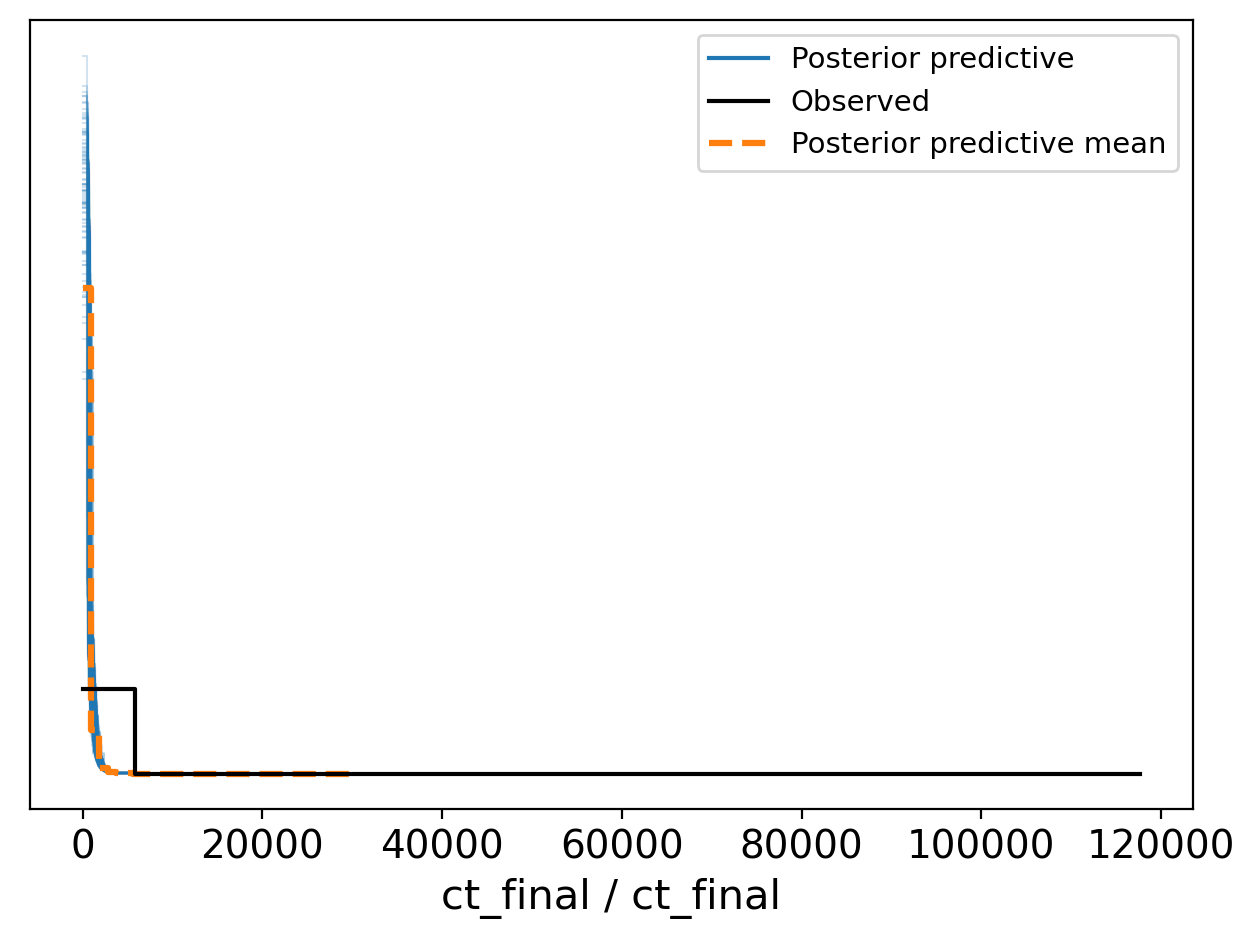

In [7]:
az.plot_ppc(trace, num_pp_samples=100, random_seed=123)
plt.tight_layout()
plt.show()

In [8]:
psis_loo = az.loo(trace, pointwise=True)
psis_loo

/home/jc604/.conda/envs/speclet_smk/lib/python3.10/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/jc604/.conda/envs/speclet_smk/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 355310 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2181409.00   644.53
p_loo    70883.62        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                          Count   Pct.
(-Inf, 0.5]   (good)     332762   93.7%
 (0.5, 0.7]   (ok)        19262    5.4%
   (0.7, 1]   (bad)        3059    0.9%
   (1, Inf)   (very bad)    227    0.1%

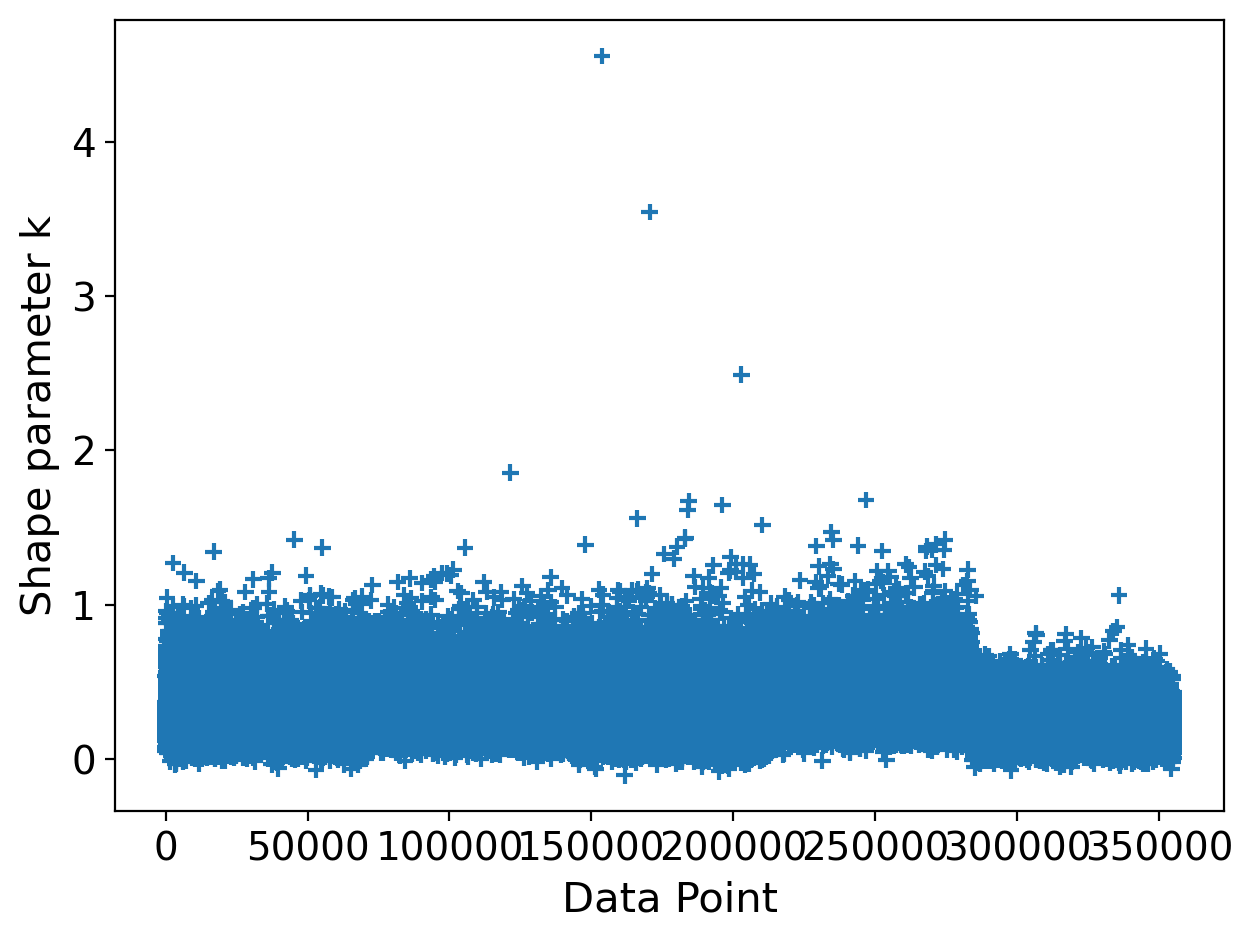

In [9]:
az.plot_khat(psis_loo)
plt.tight_layout()
plt.show()

---

In [10]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 216.64 minutes


In [11]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-08

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.66.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-h-17-51.o2.rc.hms.harvard.edu

Git branch: simplify

logging   : 0.5.1.2
speclet   : 0.0.9000
matplotlib: 3.5.2
arviz     : 0.12.1

